In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/xAI-project-computer-vision

import sys
sys.path.insert(0,'/content/drive/My Drive/Github/xAI-project-computer-vision')

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Rc4yOY9-4nyo4PuPOLW54tnaNHAfWufd/Github/xAI-project-computer-vision


In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import random
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
import models
from utils import print_model_summary, get_available_device, move_to_device, seed_all

device = get_available_device()
print("Device:", device)

seed_all(42)

Device: cuda

Device: cuda
Random seed 42 has been set.


In [ ]:
from datasets import calculate_mean_std

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.CIFAR100(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(root='data', train=False, download=True, transform=transform)

# Calculate mean and std for normalization
mean_train, std_train = calculate_mean_std(train_data)
mean_test, std_test = calculate_mean_std(test_data)

# Print mean and std
print(f'mean_train: {mean_train}')
print(f'std_train: {std_train}')
print(f'mean_test: {mean_test}')
print(f'std_test: {std_test}')

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
mean_train: [0.5071, 0.4866, 0.4409]
std_train: [0.2673, 0.2564, 0.2762]
mean_test: [0.5088, 0.4874, 0.4419]
std_test: [0.2683, 0.2574, 0.2771]


In [ ]:
# Default hyperparameters

num_classes = 100

# number of samples per batch to load
batch_size = 64

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count() if not torch.cuda.is_available() else 2
print(f'Number of workers: {num_workers}')

epochs = 10
lr = 0.001
l2 = 0 #0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = None #0.1 #None

# Data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_test, std_test)
])

Number of workers: 2


# Train simple custom CNNs

## Train simple custom CNN v1

In [ ]:
# Hyperparameters (optim_code: _9)
epochs = 20

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Dropout (dropout)                      [64, 1024]           [64, 1024]           --                   --
├─Linear (fc1)        

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.3102
Epoch: 001/020 | Batch 121/625 | Loss: 1.5773
Epoch: 001/020 | Batch 241/625 | Loss: 1.4323
Epoch: 001/020 | Batch 361/625 | Loss: 1.5518
Epoch: 001/020 | Batch 481/625 | Loss: 1.6642
Epoch: 001/020 | Batch 601/625 | Loss: 1.3627
Epoch: 001/020   Train Loss: 1.5022 | Train Acc.: 45.58% | Validation Loss: 1.2358 | Validation Acc.: 55.64%
Validation loss decreased (inf --> 1.2358).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.3399
Epoch: 002/020 | Batch 121/625 | Loss: 1.3220
Epoch: 002/020 | Batch 241/625 | Loss: 1.0375
Epoch: 002/020 | Batch 361/625 | Loss: 1.1585
Epoch: 002/020 | Batch 481/625 | Loss: 0.9330
Epoch: 002/020 | Batch 601/625 | Loss: 1.1751
Epoch: 002/020   Train Loss: 1.1443 | Train Acc.: 59.24% | Validation Loss: 1.050

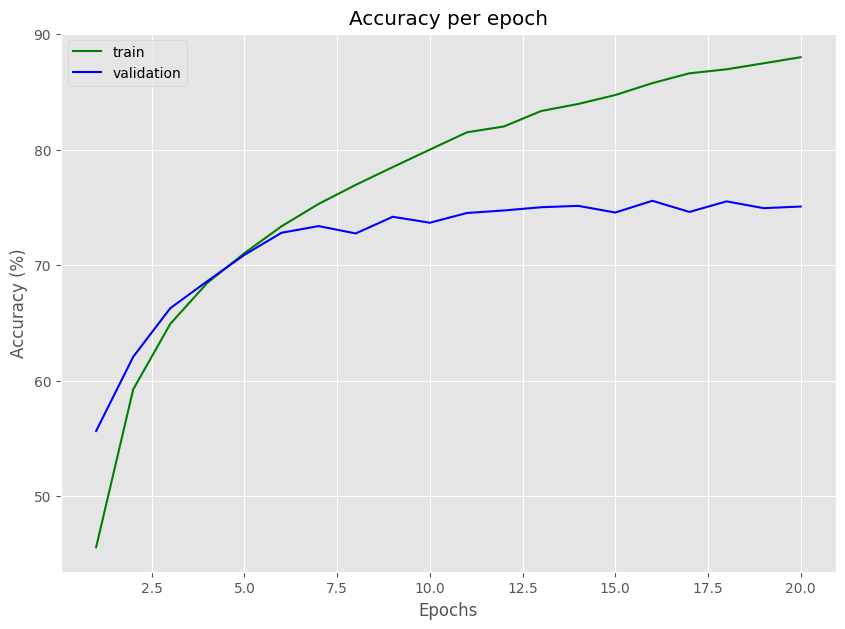

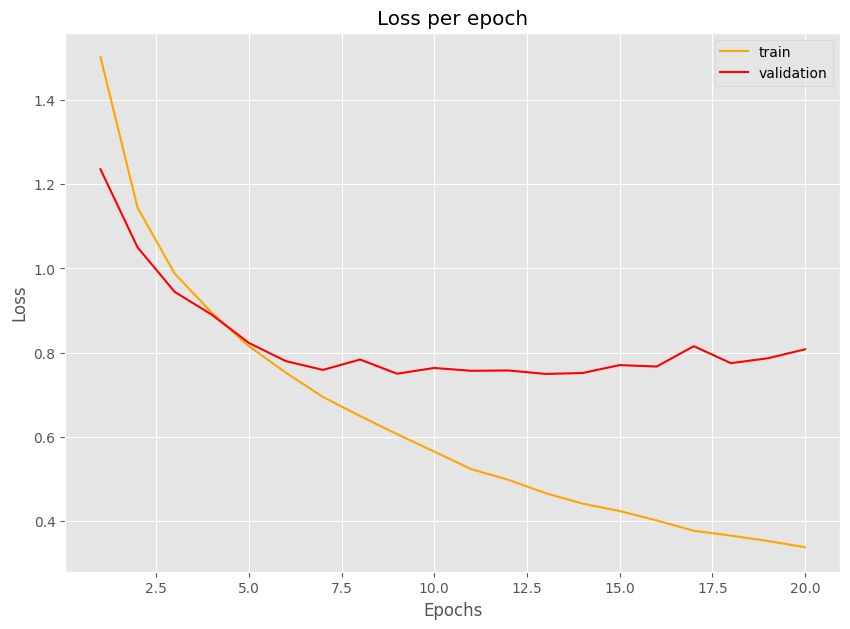

TRAINING FINISHED
CPU times: user 1min 38s, sys: 16.5 s, total: 1min 54s
Wall time: 5min 34s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_9')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_001014' --optim_code '_9' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]  

In [ ]:
# Hyperparamter (optim_code: _469)
lr = 0.01
epochs = 20

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

from datasets import prepare_data_loaders
train_dl, _ = prepare_data_loaders(num_classes, batch_size, num_workers, train_transform, test_transform)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=train_dl.__len__())

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Dropout (dropout)                      [64, 1024]           [64, 1024]           --                   --
├─Linear (fc1)        

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.3144
Epoch: 001/020 | Batch 121/625 | Loss: 1.7417
Epoch: 001/020 | Batch 241/625 | Loss: 1.5788
Epoch: 001/020 | Batch 361/625 | Loss: 1.6614
Epoch: 001/020 | Batch 481/625 | Loss: 1.6656
Epoch: 001/020 | Batch 601/625 | Loss: 1.6270
Epoch: 001/020   Train Loss: 1.6393 | Train Acc.: 40.45% | Validation Loss: 1.3849 | Validation Acc.: 50.10%
Validation loss decreased (inf --> 1.3849).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.4801
Epoch: 002/020 | Batch 121/625 | Loss: 1.4577
Epoch: 002/020 | Batch 241/625 | Loss: 1.3914
Epoch: 002/020 | Batch 361/625 | Loss: 1.2698
Epoch: 002/020 | Batch 481/625 | Loss: 1.2461
Epoch: 002/020 | Batch 601/625 | Loss: 1.3127
Epoch: 002/020   Train Loss: 1.2987 | Train Acc.: 53.16% | Validation Loss: 1.186

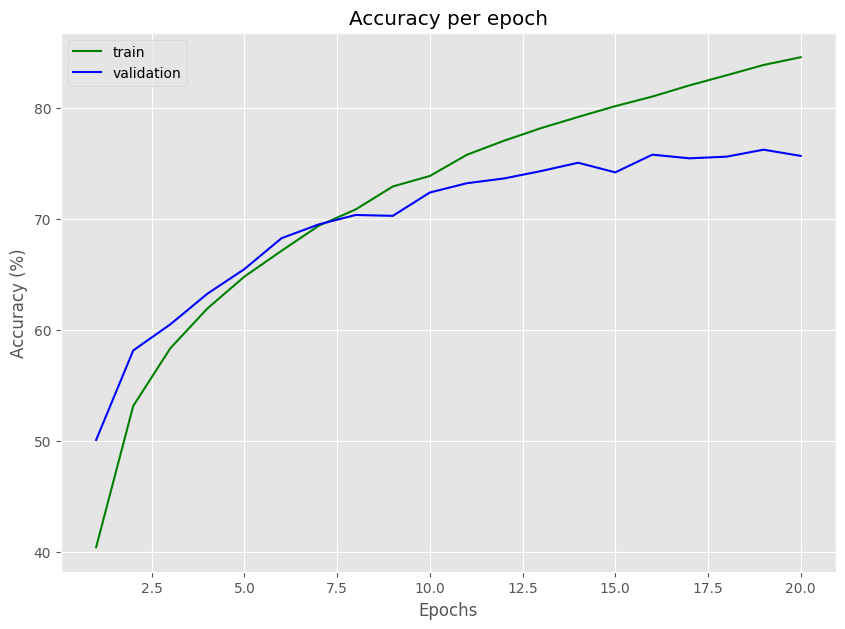

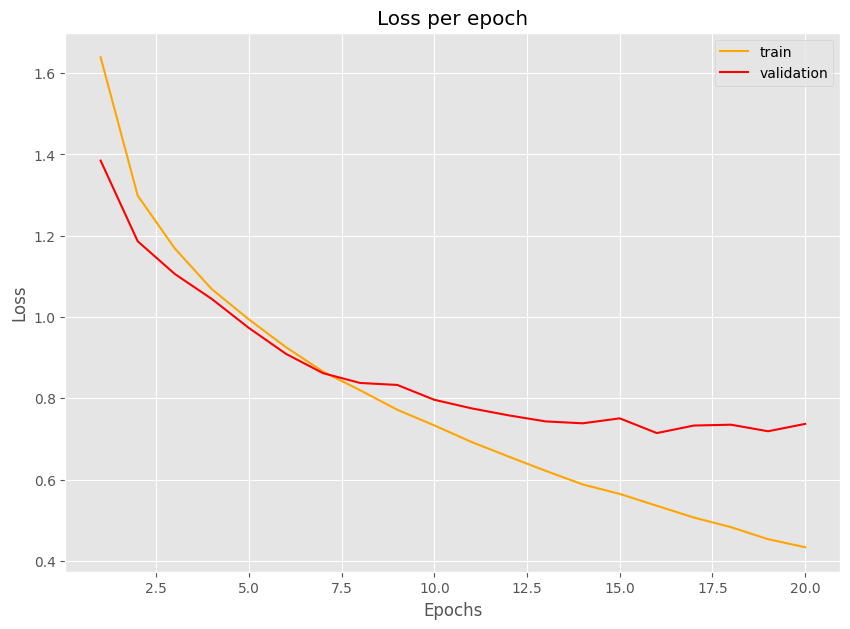

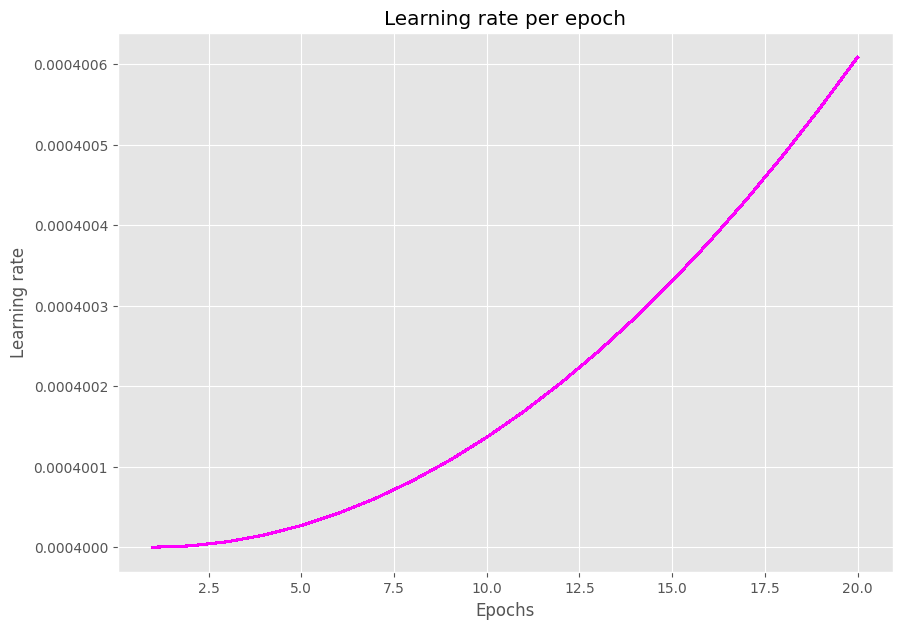

TRAINING FINISHED
CPU times: user 1min 39s, sys: 16.5 s, total: 1min 55s
Wall time: 5min 35s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
                batch_size=batch_size, num_workers=num_workers, epochs=epochs,
                lr_scheduler=lr_scheduler,
                loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
                train_transform=train_transform, test_transform=test_transform,
                optim_code='_469')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240125_235338' --optim_code '_469' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]  

In [ ]:
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1 #None

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_test, std_test),
])

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
                batch_size=batch_size, num_workers=num_workers, epochs=epochs,
                lr_scheduler=lr_scheduler,
                loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
                train_transform=train_transform, test_transform=test_transform,
                optim_code='_1359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_' --optim_code '_1359' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

## Train simple custom CNN v2

In [ ]:
# Hyperparameters (optim_code: _12359)
epochs = 20
lr = 0.0001
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('simple_convnet_v2', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNetV2 (SimpleConvNetV2)        [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 48, 32, 32]     1,344                True
├─Conv2d (conv2)                         [64, 48, 32, 32]     [64, 96, 32, 32]     41,568               True
├─MaxPool2d (pool)                       [64, 96, 32, 32]     [64, 96, 16, 16]     --                   --
├─Dropout (dropout)                      [64, 96, 16, 16]     [64, 96, 16, 16]     --                   --
├─Conv2d (conv3)                         [64, 96, 16, 16]     [64, 192, 16, 16]    166,080              True
├─Conv2d (conv4)                         [64, 192, 16, 16]    [64, 256, 16, 16]    442,624              True
├─MaxPool2d (pool)                       [64, 256, 16, 16]    [64, 256, 8, 8]      --                   --
├─Dropout (dropout) 

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.6108
Epoch: 001/020 | Batch 121/625 | Loss: 4.5765
Epoch: 001/020 | Batch 241/625 | Loss: 4.3692
Epoch: 001/020 | Batch 361/625 | Loss: 4.3686
Epoch: 001/020 | Batch 481/625 | Loss: 4.2129
Epoch: 001/020 | Batch 601/625 | Loss: 4.0487
Epoch: 001/020   Train Loss: 4.3997 | Train Acc.: 3.97% | Validation Loss: 4.0748 | Validation Acc.: 8.30%
Validation loss decreased (inf --> 4.0748).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 4.1981
Epoch: 002/020 | Batch 121/625 | Loss: 4.1975
Epoch: 002/020 | Batch 241/625 | Loss: 4.0603
Epoch: 002/020 | Batch 361/625 | Loss: 4.1788
Epoch: 002/020 | Batch 481/625 | Loss: 3.9411
Epoch: 002/020 | Batch 601/625 | Loss: 4.0890
Epoch: 002/020   Train Loss: 4.0590 | Train Acc.: 7.56% | Validation Loss: 3.8336 |

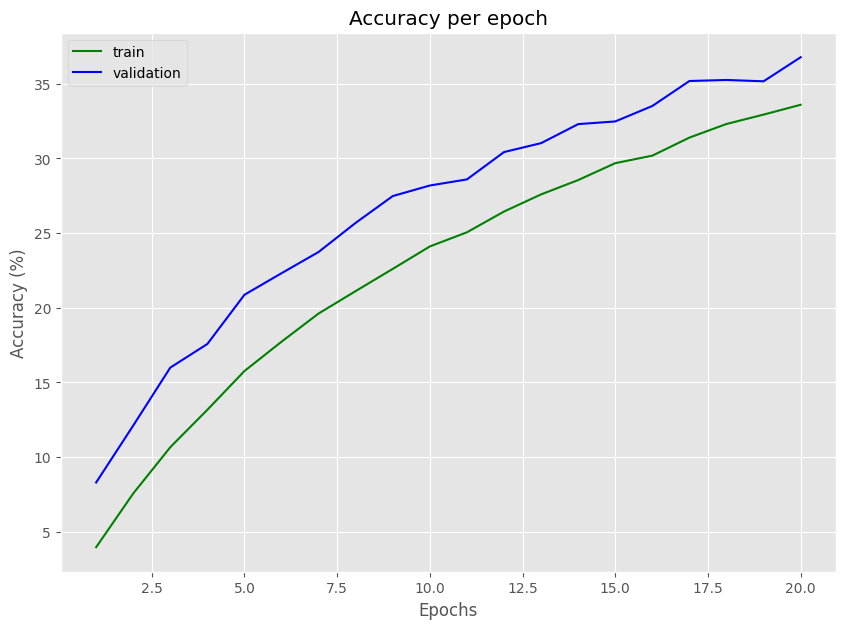

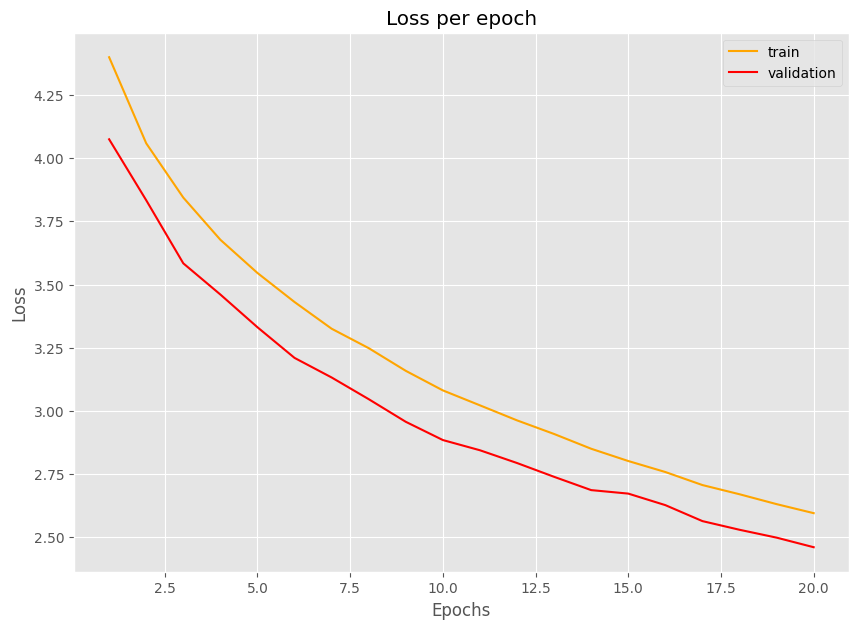

TRAINING FINISHED
CPU times: user 3min 21s, sys: 19.1 s, total: 3min 40s
Wall time: 8min 59s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet_v2',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_12359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_135550' --optim_code '_12359' --model_name 'simple_convnet_v2' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNetV2 (SimpleConvNetV2)        [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 48, 32, 32]     1,344                True
├─Conv2d (conv2)                         [64, 48, 32, 32]     [64, 96, 32, 32]     41,568               True
├─MaxPool2d (pool)                       [64, 96, 32, 32]     [64, 96, 16, 16]     --                   --
├─Dropout (dropout)                      [64, 96, 16, 16]     [64, 96, 16, 16]     --                   --
├─Conv2d (conv3)                         [64, 96, 16, 16]     [64, 192, 16, 16

# Train deeper custom CNNs (based on ResNet)

## Train simplified custom ResNet

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/010 | Batch 001/625 | Loss: 5.3940
Epoch: 001/010 | Batch 121/625 | Loss: 4.7228
Epoch: 001/010 | Batch 241/625 | Loss: 3.9988
Epoch: 001/010 | Batch 361/625 | Loss: 4.0838
Epoch: 001/010 | Batch 481/625 | Loss: 3.1785
Epoch: 001/010 | Batch 601/625 | Loss: 3.1621
Epoch: 001/010   Train Loss: 4.1964 | Train Acc.: 10.45% | Validation Loss: 3.4700 | Validation Acc.: 17.56%
Validation loss decreased (inf --> 3.4700).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/010 | Batch 001/625 | Loss: 3.1471
Epoch: 002/010 | Batch 121/625 | Loss: 3.0326
Epoch: 002/010 | Batch 241/625 | Loss: 3.1148
Epoch: 002/010 | Batch 361/625 | Loss: 2.8627
Epoch: 002/010 | Batch 481/625 | Loss: 2.1175
Epoch: 002/010 | Batch 601/625 | Loss: 2.3920
Epoch: 002/010   Train Loss: 2.8575 | Train Acc.: 29.13% | Validation Loss: 2.624

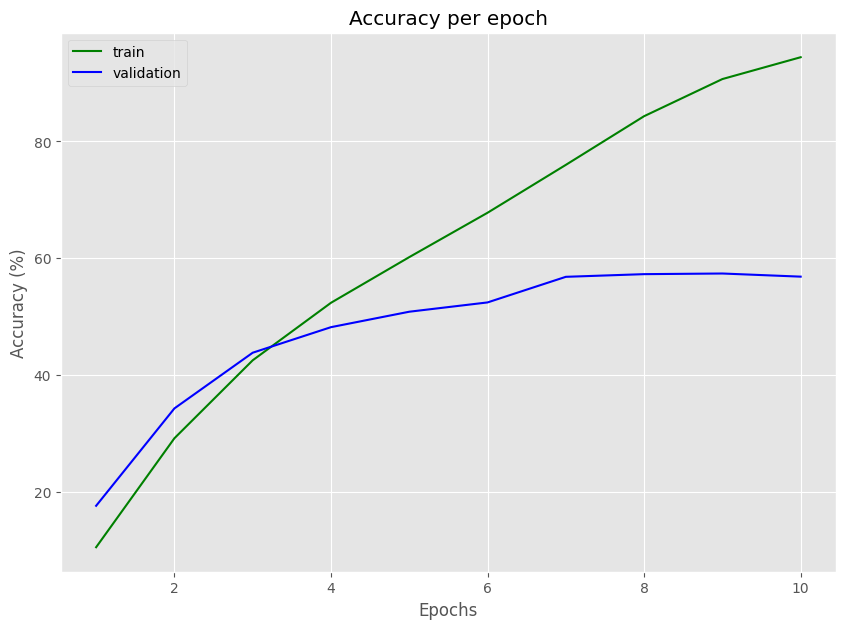

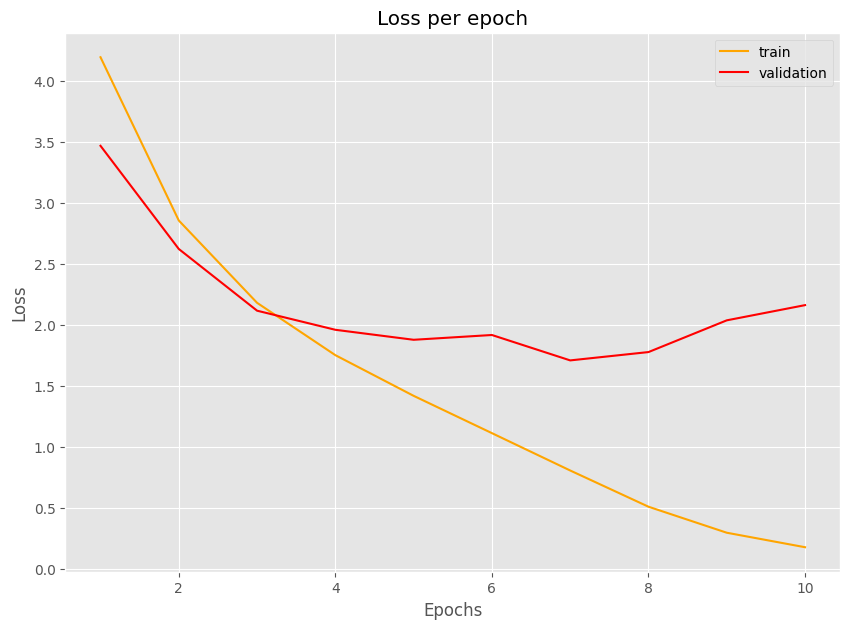

TRAINING FINISHED
CPU times: user 3min 3s, sys: 9.88 s, total: 3min 13s
Wall time: 4min 20s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform)

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_141101' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_' --optim_code '_359' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

In [ ]:
# TOP
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 5.4709
Epoch: 001/020 | Batch 121/625 | Loss: 5.0018
Epoch: 001/020 | Batch 241/625 | Loss: 4.3340
Epoch: 001/020 | Batch 361/625 | Loss: 4.1087
Epoch: 001/020 | Batch 481/625 | Loss: 3.4721
Epoch: 001/020 | Batch 601/625 | Loss: 3.4990
Epoch: 001/020   Train Loss: 4.3481 | Train Acc.: 8.24% | Validation Loss: 3.6627 | Validation Acc.: 13.95%
Validation loss decreased (inf --> 3.6627).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.3927
Epoch: 002/020 | Batch 121/625 | Loss: 3.2535
Epoch: 002/020 | Batch 241/625 | Loss: 3.5184
Epoch: 002/020 | Batch 361/625 | Loss: 3.2169
Epoch: 002/020 | Batch 481/625 | Loss: 2.5087
Epoch: 002/020 | Batch 601/625 | Loss: 2.7309
Epoch: 002/020   Train Loss: 3.1835 | Train Acc.: 22.81% | Validation Loss: 3.0212

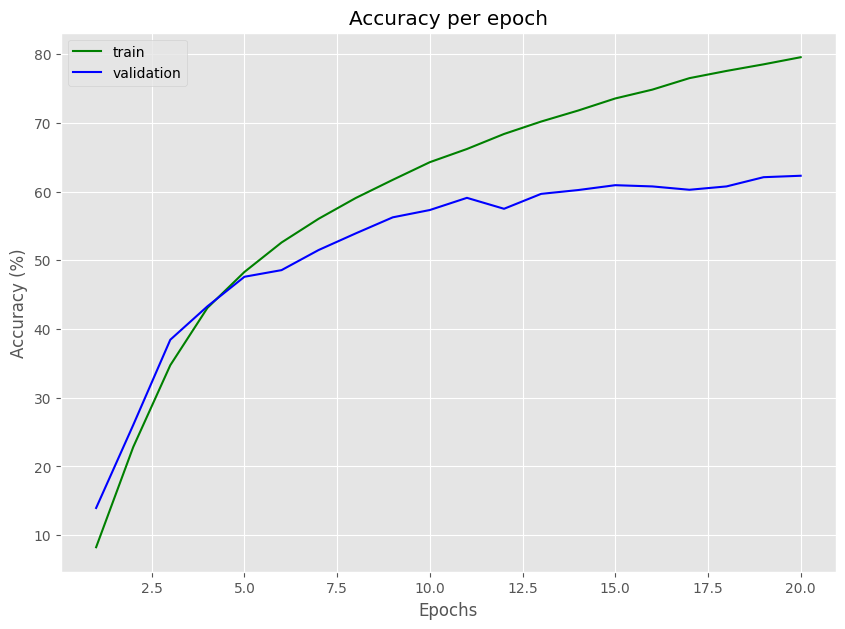

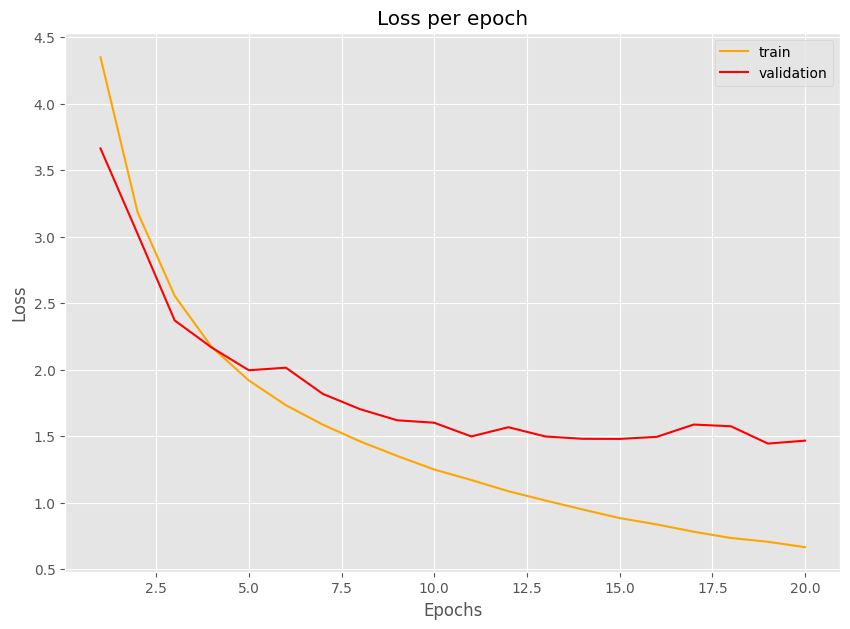

TRAINING FINISHED
CPU times: user 5min 47s, sys: 18.7 s, total: 6min 6s
Wall time: 10min 12s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_134040' --optim_code '_1359' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _1459f)
epochs = 20
l2 = 0.001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

from datasets import prepare_data_loaders
train_dl, _ = prepare_data_loaders(num_classes, batch_size, num_workers, train_transform, test_transform)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=train_dl.__len__())

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 5.3661
Epoch: 001/020 | Batch 121/625 | Loss: 4.0216
Epoch: 001/020 | Batch 241/625 | Loss: 3.3700
Epoch: 001/020 | Batch 361/625 | Loss: 3.6750
Epoch: 001/020 | Batch 481/625 | Loss: 3.0337
Epoch: 001/020 | Batch 601/625 | Loss: 3.0203
Epoch: 001/020   Train Loss: 3.6732 | Train Acc.: 15.25% | Validation Loss: 3.2360 | Validation Acc.: 22.28%
Validation loss decreased (inf --> 3.2360).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.2536
Epoch: 002/020 | Batch 121/625 | Loss: 2.9831
Epoch: 002/020 | Batch 241/625 | Loss: 3.3716
Epoch: 002/020 | Batch 361/625 | Loss: 3.0738
Epoch: 002/020 | Batch 481/625 | Loss: 2.6504
Epoch: 002/020 | Batch 601/625 | Loss: 2.8361
Epoch: 002/020   Train Loss: 3.0248 | Train Acc.: 26.15% | Validation Loss: 2.846

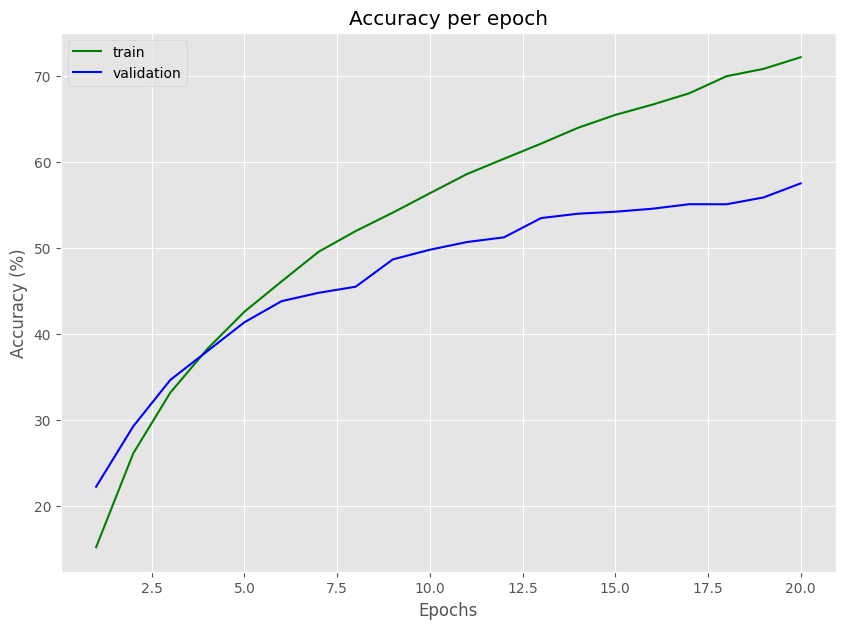

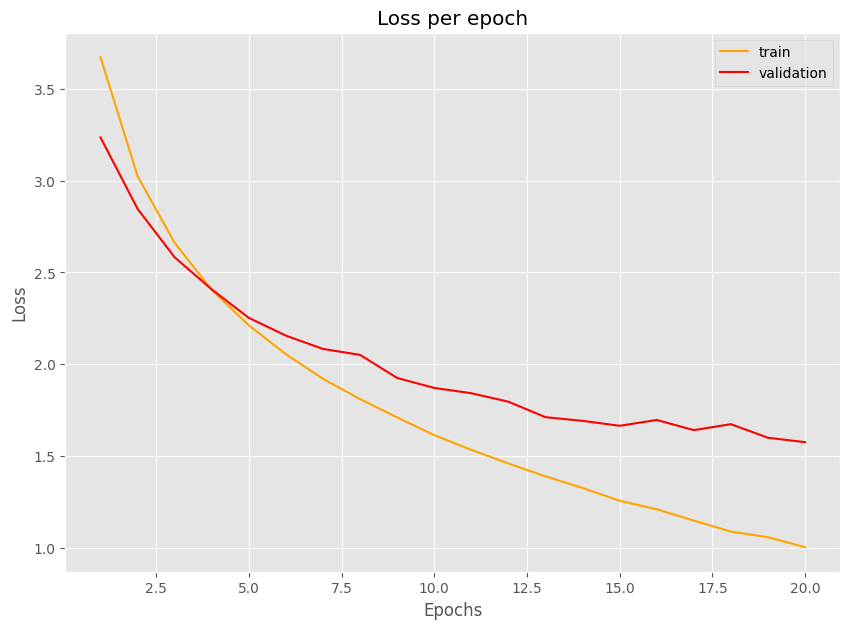

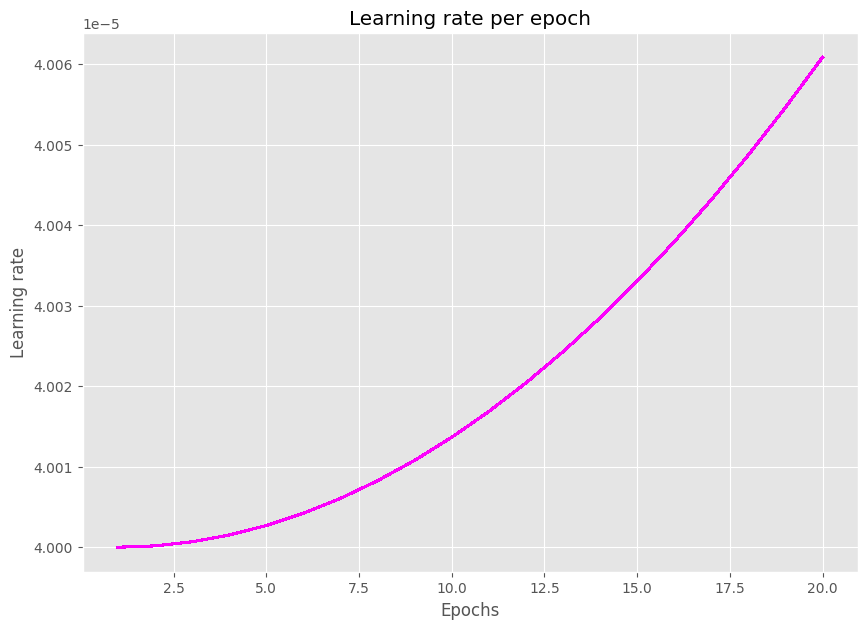

TRAINING FINISHED
CPU times: user 5min 42s, sys: 19.8 s, total: 6min 2s
Wall time: 10min 32s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1459f')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_142847' --optim_code '_1459f' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _359e)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 5.3857
Epoch: 001/020 | Batch 121/625 | Loss: 5.0458
Epoch: 001/020 | Batch 241/625 | Loss: 4.3051
Epoch: 001/020 | Batch 361/625 | Loss: 4.2497
Epoch: 001/020 | Batch 481/625 | Loss: 3.7898
Epoch: 001/020 | Batch 601/625 | Loss: 3.7353
Epoch: 001/020   Train Loss: 4.5361 | Train Acc.: 5.57% | Validation Loss: 3.9273 | Validation Acc.: 9.34%
Validation loss decreased (inf --> 3.9273).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.8003
Epoch: 002/020 | Batch 121/625 | Loss: 3.7757
Epoch: 002/020 | Batch 241/625 | Loss: 3.9562
Epoch: 002/020 | Batch 361/625 | Loss: 3.8090
Epoch: 002/020 | Batch 481/625 | Loss: 3.2633
Epoch: 002/020 | Batch 601/625 | Loss: 3.3853
Epoch: 002/020   Train Loss: 3.6785 | Train Acc.: 13.70% | Validation Loss: 3.4250 

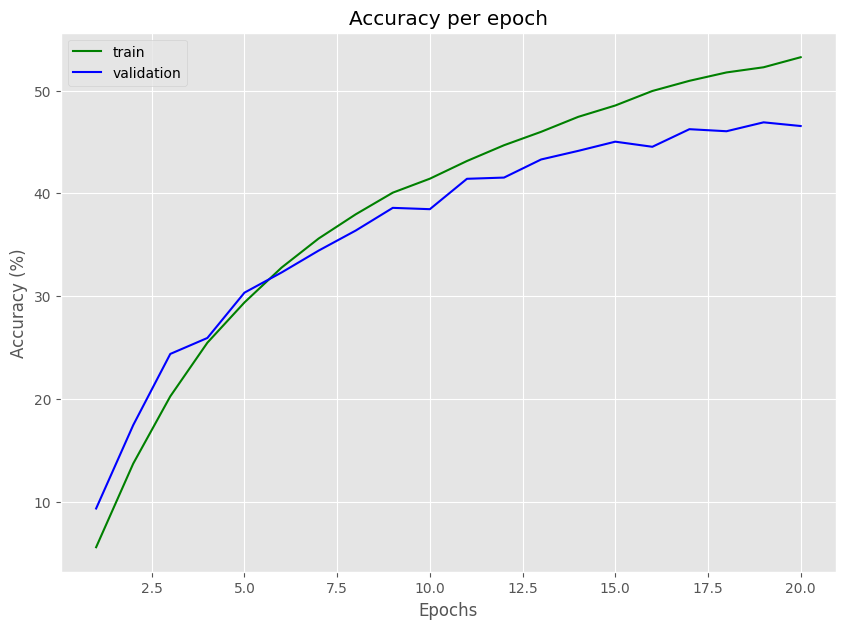

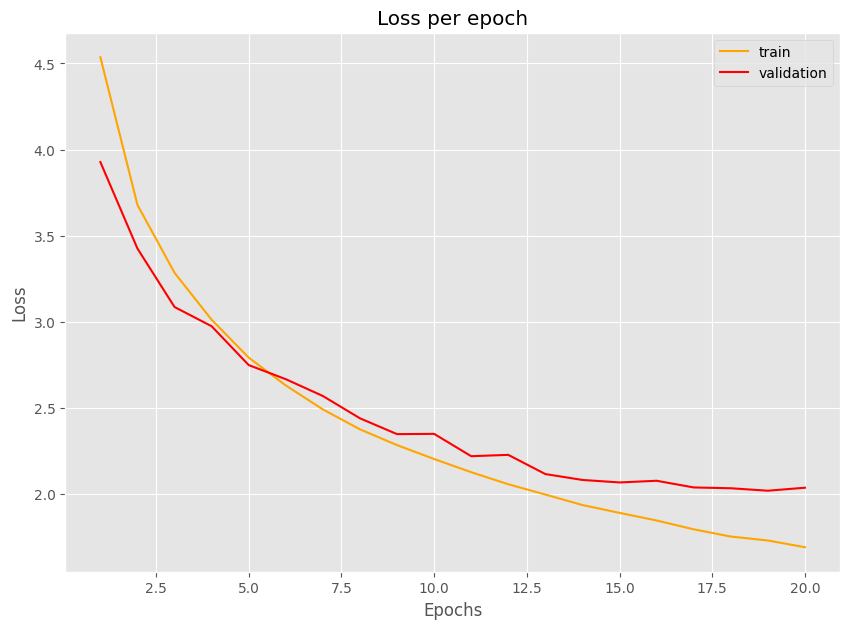

TRAINING FINISHED
CPU times: user 5min 18s, sys: 20.3 s, total: 5min 38s
Wall time: 21min 56s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359e')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_144942' --optim_code '_359e' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _359g)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ColorJitter(brightness=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 5.3643
Epoch: 001/020 | Batch 121/625 | Loss: 5.5914
Epoch: 001/020 | Batch 241/625 | Loss: 4.6312
Epoch: 001/020 | Batch 361/625 | Loss: 4.3105
Epoch: 001/020 | Batch 481/625 | Loss: 3.9644
Epoch: 001/020 | Batch 601/625 | Loss: 3.7415
Epoch: 001/020   Train Loss: 4.5610 | Train Acc.: 5.34% | Validation Loss: 3.9150 | Validation Acc.: 10.26%
Validation loss decreased (inf --> 3.9150).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.7731
Epoch: 002/020 | Batch 121/625 | Loss: 3.6908
Epoch: 002/020 | Batch 241/625 | Loss: 3.9881
Epoch: 002/020 | Batch 361/625 | Loss: 3.2585
Epoch: 002/020 | Batch 481/625 | Loss: 3.0779
Epoch: 002/020 | Batch 601/625 | Loss: 3.4890
Epoch: 002/020   Train Loss: 3.5963 | Train Acc.: 15.73% | Validation Loss: 3.4102

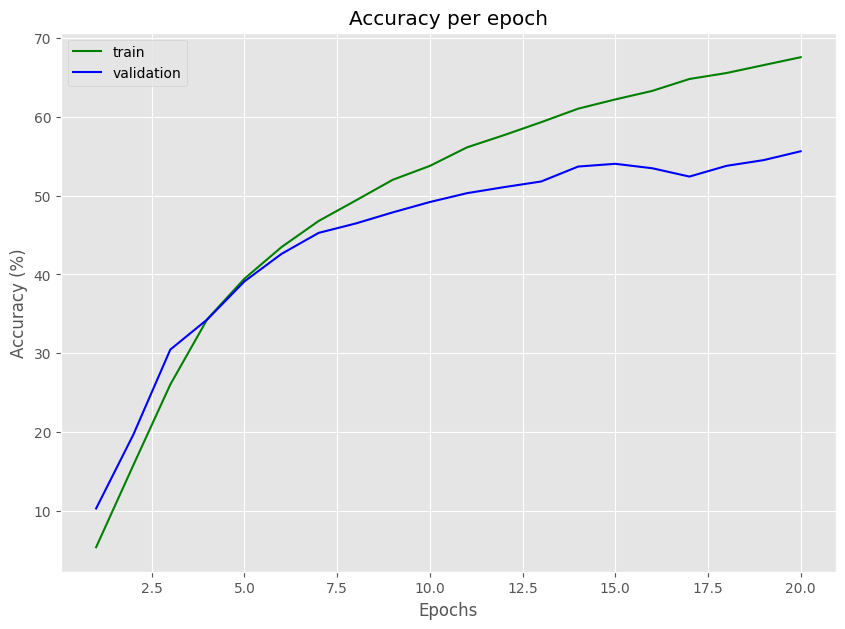

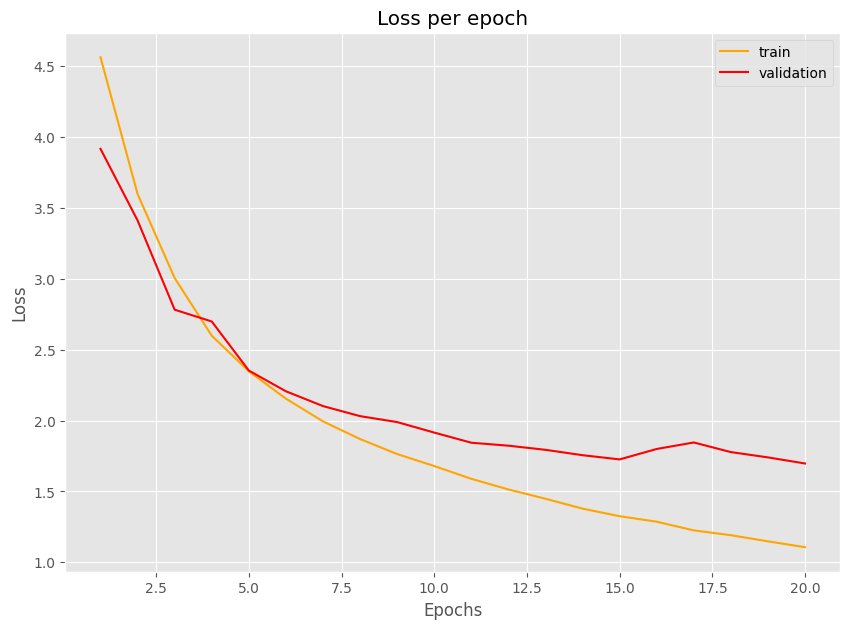

TRAINING FINISHED
CPU times: user 5min 3s, sys: 18.9 s, total: 5min 22s
Wall time: 16min 59s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359g')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_155438' --optim_code '_359g' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _359d)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359d')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_' --optim_code '_359d' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

## Train custom ResNet18

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform)

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

In [ ]:
# TOP
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.7329
Epoch: 001/020 | Batch 121/625 | Loss: 4.2232
Epoch: 001/020 | Batch 241/625 | Loss: 3.8647
Epoch: 001/020 | Batch 361/625 | Loss: 4.0541
Epoch: 001/020 | Batch 481/625 | Loss: 3.5542
Epoch: 001/020 | Batch 601/625 | Loss: 3.5494
Epoch: 001/020   Train Loss: 3.9559 | Train Acc.: 8.75% | Validation Loss: 3.5713 | Validation Acc.: 13.68%
Validation loss decreased (inf --> 3.5713).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.5237
Epoch: 002/020 | Batch 121/625 | Loss: 3.4040
Epoch: 002/020 | Batch 241/625 | Loss: 3.8352
Epoch: 002/020 | Batch 361/625 | Loss: 3.2578
Epoch: 002/020 | Batch 481/625 | Loss: 2.8856
Epoch: 002/020 | Batch 601/625 | Loss: 3.1273
Epoch: 002/020   Train Loss: 3.3441 | Train Acc.: 18.47% | Validation Loss: 3.1824

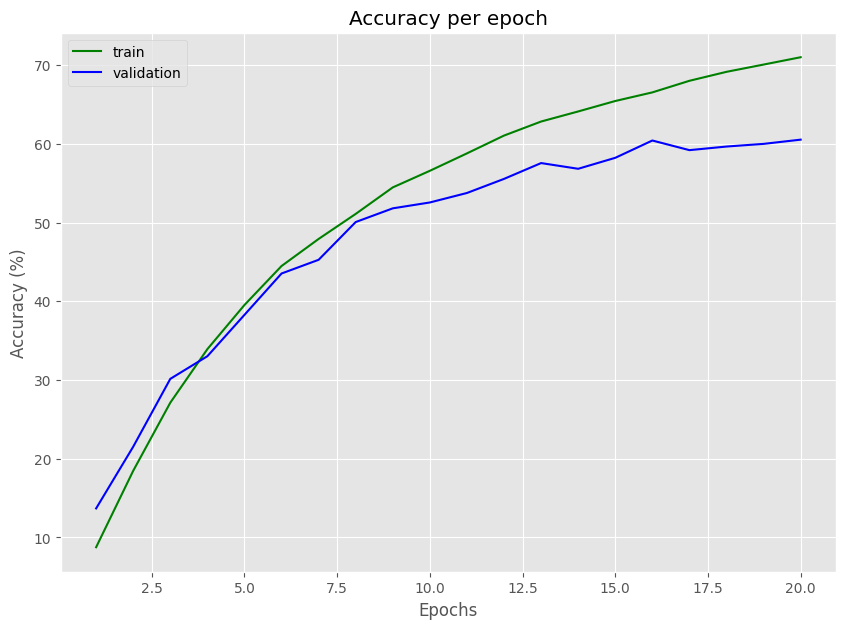

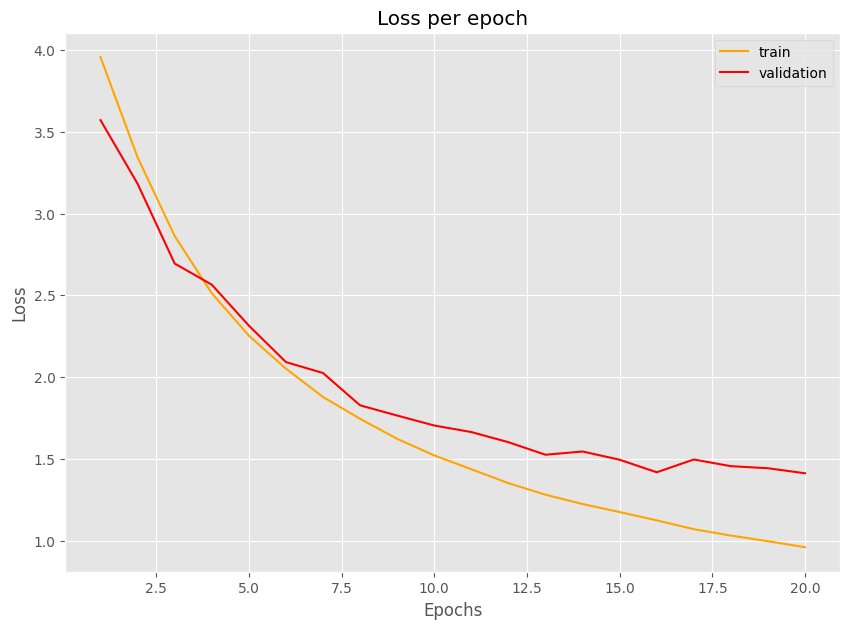

TRAINING FINISHED
CPU times: user 12min 56s, sys: 22.6 s, total: 13min 18s
Wall time: 16min 32s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_131558' --optim_code '_1359' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _359b)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359b')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_' --optim_code '_359b' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _359c)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359c')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_' --optim_code '_359c' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _359d)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359d')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20231207_' --optim_code '_359d' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

## Train custom ResNet50

In [ ]:
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     4,096                True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.7969
Epoch: 001/020 | Batch 121/625 | Loss: 4.4314
Epoch: 001/020 | Batch 241/625 | Loss: 4.1335
Epoch: 001/020 | Batch 361/625 | Loss: 4.1031
Epoch: 001/020 | Batch 481/625 | Loss: 3.8044
Epoch: 001/020 | Batch 601/625 | Loss: 3.6731
Epoch: 001/020   Train Loss: 4.1664 | Train Acc.: 6.35% | Validation Loss: 3.7516 | Validation Acc.: 10.68%
Validation loss decreased (inf --> 3.7516).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.6745
Epoch: 002/020 | Batch 121/625 | Loss: 3.6002
Epoch: 002/020 | Batch 241/625 | Loss: 3.8320
Epoch: 002/020 | Batch 361/625 | Loss: 3.6040
Epoch: 002/020 | Batch 481/625 | Loss: 3.3367
Epoch: 002/020 | Batch 601/625 | Loss: 3.4121
Epoch: 002/020   Train Loss: 3.5822 | Train Acc.: 14.36% | Validation Loss: 3.3482

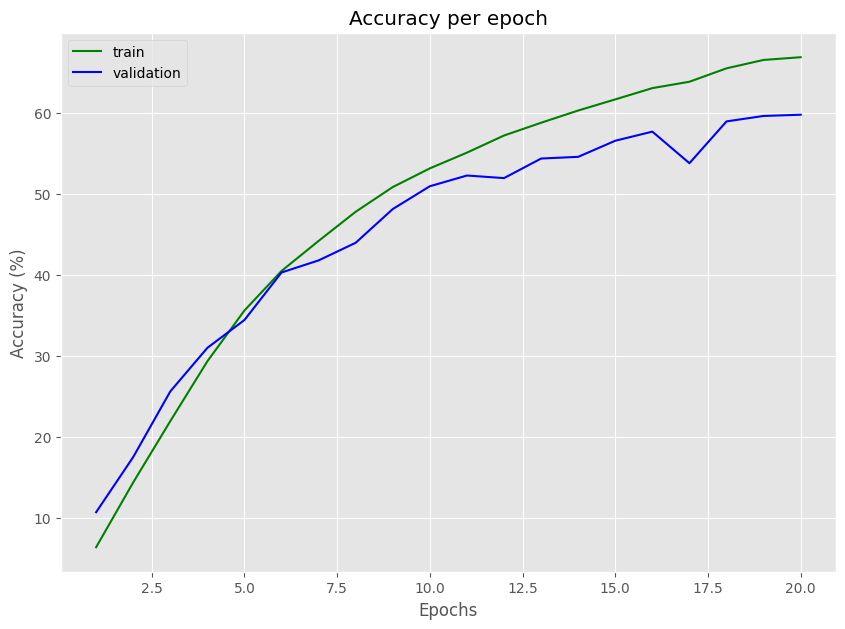

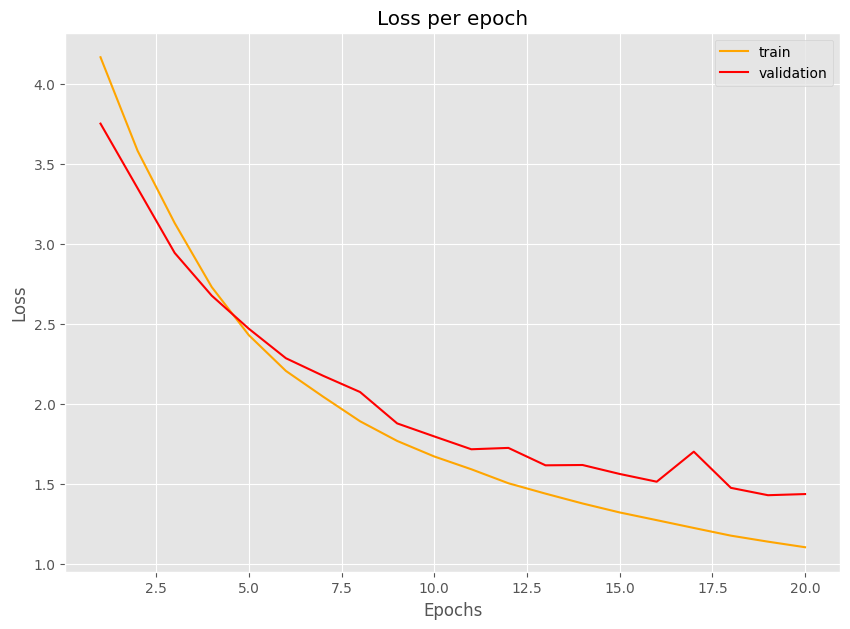

TRAINING FINISHED
CPU times: user 47min 27s, sys: 32.2 s, total: 47min 59s
Wall time: 51min 29s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')


In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_162952' --optim_code '_1359' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _1389h)
batch_size = 128
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.5

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1389h')


In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126' --optim_code '_1389h' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _359b)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359b')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20231207_093202' --optim_code '_359b' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2